In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy

import pandas as pd
import plotly
import plotly.express as px
from plotly.graph_objs import Figure, Layout, Scatter3d
import torch
import sklearn.datasets
import torch.nn as nn
from torchdiffeq import odeint_adjoint as odeint

gradient flow part

In [2]:
# Generate data
def generate_data(name=''):
    dim = 2
    if name == 'ellipse':
        num = 100
        source_samples , color = sklearn.datasets.make_circles(n_samples=2*num, shuffle=False)
        target_samples , color = sklearn.datasets.make_circles(n_samples=2*num, shuffle=False)
        source_samples = source_samples[:num]
        target_samples = target_samples[:num]
        source_samples[:,0]*=1.5
        target_samples[:,0]*=1.5
        target_samples[:,[0,1]] = target_samples[:,[1,0]]
        target_samples[:,0]*=-1
    elif name == 'cat':
        num = 500
        source_samples = np.load('cat_500.npy')
        source_samples -= source_samples.mean(axis=0)
        target_samples = np.load('cat_500.npy')
        target_samples -= target_samples.mean(axis=0)
        target_samples[:,[0,1]] = target_samples[:,[1,0]]
        target_samples[:,0]*=-1
    elif name == 'heart':
        num = 500
        source_samples = np.load('heart_500.npy')
        source_samples -= source_samples.mean(axis=0)
        target_samples = np.load('heart_500.npy')
        target_samples -= target_samples.mean(axis=0)
        source_samples[:,1]*=2
        target_samples[:,1]*=2
        target_samples[:,[0,1]] = target_samples[:,[1,0]]
        target_samples[:,0]*=-1
    elif name == 'cat_heart':
        num = 500
        source_samples = np.load('cat_500.npy')
        source_samples -= source_samples.mean(axis=0)
        target_samples = np.load('heart_500.npy')
        target_samples -= target_samples.mean(axis=0)
        target_samples[:,1]*=2
    elif name == 'cat_rotated_heart':
        num = 500
        source_samples = np.load('cat_500.npy')
        source_samples -= source_samples.mean(axis=0)
        target_samples = np.load('heart_500.npy')
        target_samples -= target_samples.mean(axis=0)
        target_samples[:,1]*=2
        target_samples[:,[0,1]] = target_samples[:,[1,0]]
        target_samples[:,0]*=-1
    elif name == 'square':
        num = 200
        side1 = np.concatenate(([np.linspace(-1,1,num=50)],[np.ones(50)]), axis=0).T
        side2 = np.concatenate(([np.linspace(-1,1,num=50)],[-np.ones(50)]), axis=0).T
        side3 = np.concatenate(([np.ones(50)],[np.linspace(-1+0.02,1-0.02,num=50)]), axis=0).T
        side4 = np.concatenate(([-np.ones(50)],[np.linspace(-1+0.02,1-0.02,num=50)]), axis=0).T
        source_samples = np.concatenate((side1,side2,side3,side4),axis=0)
        target_samples = source_samples.copy()
    elif name == 'infinity':
        num = 100
        t = np.linspace(0, 2 * np.pi, 100)  # parameter t
        a = 1  # scaling factor
        x = a * np.cos(t) / (1 + np.sin(t)**2)
        y = a * np.cos(t) * np.sin(t) / (1 + np.sin(t)**2)
        noise_level = 0
        x_noisy = x + noise_level * np.random.normal(size=x.shape)
        y_noisy = y + noise_level * np.random.normal(size=y.shape)
        source_samples = np.concatenate(([x_noisy],[y_noisy]),axis=0).T
        source_samples -= source_samples.mean(axis=0)
        target_samples = source_samples.copy()
    elif name == 'moon':
        num = 200
        source_samples, color = sklearn.datasets.make_moons(n_samples=num, noise=0.05, random_state=170)
        source_samples -= source_samples.mean(axis=0)
        target_samples = source_samples.copy()
    elif name == 'two_circle':
        num = 200
        source_samples , color = sklearn.datasets.make_circles(n_samples=num, shuffle=False)
        source_samples -= source_samples.mean(axis=0)
        target_samples = source_samples.copy()

    
    source = source_samples.copy()
    target = target_samples.copy()
    source_samples = source_samples.astype(np.float32)
    target_samples = target_samples.astype(np.float32)
    source_samples = torch.from_numpy(source_samples)
    target_samples = torch.from_numpy(target_samples)
    return num, dim, source, target, source_samples, target_samples


In [3]:
# training setup
bandwidth = 0.03

class VelocityFieldNN(nn.Module):
    def __init__(self):
        super(VelocityFieldNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 2)
        )

    def forward(self, t, x):
        tx = torch.cat((x, t.expand(x.shape[0], 1)), dim=1)
        return self.net(tx)


# the two energy
def kinetic_energy_loss(velocities):
    return torch.mean(torch.sum(velocities ** 2, dim=-1))

def GW_kinetic_energy_loss(velocities,rho):
    q = torch.mean(torch.sum(velocities * (velocities@rho.T@rho/num),dim=1))
    cov = rho.T@velocities/num
    return 2*q+2*torch.sum(cov*cov.T)


def transport_loss_MMD(transported_samples, target_samples):
    return MMD(bandwidth, transported_samples, transported_samples) + MMD(bandwidth, target_samples, target_samples) - 2*MMD(bandwidth, transported_samples, target_samples)

def MMD(sigma,X1,X2):
    square = torch.cdist(X1,X2, p=2)**2
    val=torch.exp(-square/sigma)  + torch.exp(-square/(sigma*0.25))  + torch.exp(-square/(sigma*0.05))  + torch.exp(-square/(sigma*4))  + torch.exp(-square/(sigma*20))  + torch.exp(-square/(sigma*0.01)) + torch.exp(-square/(sigma*0.001))+torch.exp(-square/(sigma*0.0001))+ torch.exp(-square/(sigma*100))+ torch.exp(-square/(sigma*1000))
    return torch.mean(val)

frame_num = 10

In [39]:
# Choose experiments in ['ellipse', 'cat', 'heart', 'cat_heart', 'cat_rotated_heart']
data_name = 'ellipse'
num, dim, source, target, source_samples, target_samples = generate_data(data_name)
# Choose bettween 'W' for Wasserstein flow or 'GW' for IGW flow
method_name = 'GW'

v_model = VelocityFieldNN()

# Simulate the transport process
frame_num = 10
t = torch.linspace(0., 1., frame_num)  # Start and end of the transport
v_optimizer = torch.optim.Adam(v_model.parameters(), lr=0.001)


for epoch in range(200):
    v_optimizer.zero_grad()
    trajectory = odeint(v_model, source_samples, t, method='dopri5')
        
    # Compute velocities at each time step for kinetic energy loss
    velocities = [v_model(t[i], trajectory[i]) for i in range(len(t))]    
    # Compute last step MMD gap
    transport_loss_val = transport_loss_MMD(trajectory[-1], target_samples)

    if method_name=='W':
        kinetic_energy_loss_val = torch.mean(torch.stack([kinetic_energy_loss(v) for v in velocities]))
        total_loss = kinetic_energy_loss_val + 100*transport_loss_val
    elif method_name=='GW':
        GW_kinetic_energy_loss_val = torch.mean(torch.stack([GW_kinetic_energy_loss(v,rho) for v,rho in zip(velocities,trajectory)]))
        total_loss = GW_kinetic_energy_loss_val + 10*transport_loss_val
    
    total_loss.backward()
    v_optimizer.step()

    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {GW_kinetic_energy_loss_val.item()}, {transport_loss_val.item()}")

if method_name=='W':
    print('kinetic energy is ', kinetic_energy_loss_val.detach().numpy(), ', last step MMD gap is', transport_loss_val.detach().numpy(),)
elif method_name=='GW':
    print('kinetic energy is ', GW_kinetic_energy_loss_val.detach().numpy(), ', last step MMD gap is', transport_loss_val.detach().numpy(),)

torch.save(v_model.state_dict(), 'trained_nn/'+method_name+'_'+data_name+'_vtx.pt')

Epoch 0, Loss: 0.04103042930364609, 0.04295158386230469
Epoch 10, Loss: 0.04244194179773331, 0.047699689865112305
Epoch 20, Loss: 0.04314596578478813, 0.049141883850097656
Epoch 30, Loss: 0.04547445848584175, 0.05179595947265625
Epoch 40, Loss: 0.04229302331805229, 0.04477667808532715
Epoch 50, Loss: 0.03966515138745308, 0.042035579681396484
Epoch 60, Loss: 0.03797118738293648, 0.04730963706970215
Epoch 70, Loss: 0.04462280124425888, 0.05366778373718262
Epoch 80, Loss: 0.04097406938672066, 0.044969797134399414
Epoch 90, Loss: 0.04460642486810684, 0.04544258117675781
Epoch 100, Loss: 0.03790125995874405, 0.05080246925354004
Epoch 110, Loss: 0.042806386947631836, 0.04755973815917969
Epoch 120, Loss: 0.04277832433581352, 0.04553055763244629
Epoch 130, Loss: 0.0406123623251915, 0.03840208053588867
Epoch 140, Loss: 0.04664404317736626, 0.05355262756347656
Epoch 150, Loss: 0.0432371124625206, 0.04159259796142578
Epoch 160, Loss: 0.04221153259277344, 0.038992881774902344
Epoch 170, Loss: 0.04

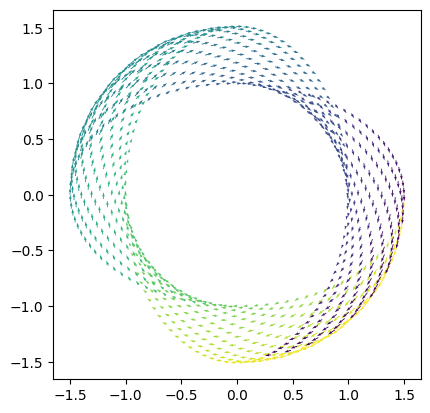

In [42]:
# Flow trajectory
v_model = VelocityFieldNN()
v_model.load_state_dict(torch.load('trained_nn/'+method_name+'_'+data_name+'_vtx.pt'))
v_model.eval()


t = torch.linspace(0., 1., frame_num)
final_trajectory = odeint(v_model, source_samples, t, method='dopri5')
flow_loc = torch.cat([rho for rho in final_trajectory], dim=0)
flow_dir = torch.cat([v_model(t[i], final_trajectory[i]) for i in range(len(t))], dim=0)
flow_loc = flow_loc.detach().numpy()
flow_dir = flow_dir.detach().numpy()
final_trajectory = final_trajectory.detach().numpy()
plt.quiver(flow_loc[:,0],flow_loc[:,1], flow_dir[:,0],flow_dir[:,1], np.tile(np.arange(num),frame_num))
plt.gca().set_aspect('equal', adjustable='box')